In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm import tqdm

In [3]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
pd.options.display.max_columns = None

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load transactions

In [7]:
# ' '.join(transactions_train['article_id'].value_counts().head(12).index.tolist())

In [8]:
transactions_train = pd.read_csv('data/transactions_train.csv', dtype={'article_id': str})
print(transactions_train.shape)
transactions_train.head()

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [9]:
transactions_train['t_dat'] = pd.to_datetime(transactions_train['t_dat'])

In [10]:
transactions_train.groupby('customer_id')['article_id'].count().describe()

count    1.362281e+06
mean     2.333463e+01
std      3.924225e+01
min      1.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.700000e+01
max      1.895000e+03
Name: article_id, dtype: float64

### Load articles

In [11]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str},
    usecols=['article_id', 'garment_group_name', 'detail_desc']
)
print(articles_df.shape)
articles_df.head()

(105542, 3)


,article_id,garment_group_name,detail_desc
0,0108775015,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [12]:
articles_df.isnull().sum()

article_id              0
garment_group_name      0
detail_desc           416
dtype: int64

In [13]:
articles_df['detail_desc'] = np.where(
    articles_df['detail_desc'].isnull(), 
    articles_df['garment_group_name'], 
    articles_df['detail_desc']
)

### Find cut-offs

In [14]:
end = transactions_train['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)
endm2 = endm1 - datetime.timedelta(days=7)
endm3 = endm2 - datetime.timedelta(days=7)

In [15]:
end, endm1, endm2, endm3

(Timestamp('2020-09-22 00:00:00'),
 Timestamp('2020-09-15 00:00:00'),
 Timestamp('2020-09-08 00:00:00'),
 Timestamp('2020-09-01 00:00:00'))

train
- inputs: start - endm3
- labels: emdm3 - endm2

dev
- inputs: start - endm2
- labels: emdm2 - endm1

test 
- inputs: start - endm1
- labels: endm1 - end

In [16]:
# transactions_train = transactions_train.copy()[transactions_train['t_dat'] > '2020-05-01']

In [17]:
transactions_train['customer_id'].nunique()

1362281

In [18]:
# % of items in last week which didn't appear in prior weeks' transactions
len(set(transactions_train[transactions_train['t_dat'] > endm1]['article_id']) - set(transactions_train[transactions_train['t_dat'] <= endm1]['article_id'])) / transactions_train[transactions_train['t_dat'] > endm1]['article_id'].nunique()

0.0370843989769821

In [19]:
transactions_train.shape

(31788324, 5)

In [20]:
transactions_train['article_id'].nunique() / articles_df.shape[0]

0.9905724735176518

### Filter out unnecessary articles

In [21]:
articles_df = articles_df.copy()[
    articles_df['article_id'].isin(transactions_train['article_id'].unique())
]

articles_df.reset_index(drop=True, inplace=True)
articles_df.drop(columns=['garment_group_name'], inplace=True)
print(articles_df.shape)
articles_df.head()

(104547, 2)


,article_id,detail_desc
0,0108775015,Jersey top with narrow shoulder straps.
1,0108775044,Jersey top with narrow shoulder straps.
2,0108775051,Jersey top with narrow shoulder straps.
3,0110065001,"Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,"Microfibre T-shirt bra with underwired, moulde..."


In [22]:
articles_df['article_id_idx'] = articles_df.index

In [23]:
article_id_to_idx = dict(zip(articles_df['article_id'], articles_df['article_id_idx']))

In [24]:
transactions_train['article_id_idx'] = transactions_train['article_id'].map(article_id_to_idx)
transactions_train['article_id_idx'] = transactions_train['article_id_idx'].astype(str)

### Create splits

#### Illustrative steps:

In [25]:
dev_labels = transactions_train.copy()[transactions_train['t_dat'] > endm1]

In [ ]:
dev_inputs = transactions_train.copy()[transactions_train['t_dat'] <= endm1]

In [ ]:
print(dev_inputs.shape)
dev_inputs.head()

In [ ]:
dev_inputs.sort_values(['customer_id', 't_dat'], inplace=True)
dev_inputs.head()

In [ ]:
# dev_inputs['total_purchases'] = dev_inputs.groupby('customer_id')['article_id'].transform('count')

In [ ]:
# print(dev_inputs.shape)
# dev_inputs = dev_inputs.copy()[dev_inputs['total_purchases'] >= 10]
# print(dev_inputs.shape)

In [ ]:
dev_inputs['article_id_idx'] = dev_inputs['article_id_idx'].astype(str)

- Age of last transaction
- Transaction count
- Incoporate count in vector representation

In [ ]:
latest_transaction_date_by_cust = dev_inputs.groupby('customer_id')[['customer_id', 't_dat']].tail(1)
latest_transaction_date_by_cust.head()

In [ ]:
dev_inputs = (
    dev_inputs
        .groupby('customer_id')
        .tail(10)  # Most recent articles only
        .groupby('customer_id')['article_id_idx']
        .apply(lambda x: ','.join(x))
        .reset_index()
)
print(dev_inputs.shape)
dev_inputs.head()

In [ ]:
dev_inputs = dev_inputs.merge(latest_transaction_date_by_cust.rename(columns={'t_dat': 't_dat_latest'}), on='customer_id')
print(dev_inputs.shape)
dev_inputs.head()

In [ ]:
dev_labels.shape

In [ ]:
dev_labels.head()

In [ ]:
num_purchases_df = dev_labels.groupby(['customer_id', 'article_id'])['t_dat'].count().reset_index().rename(columns={'t_dat': 'num_purchases'})
print(num_purchases_df.shape)
num_purchases_df.head()

In [ ]:
num_purchases_df['num_purchases'] = num_purchases_df['num_purchases'].astype(str)

In [ ]:
dev_labels = num_purchases_df.groupby('customer_id').agg(
    {
        'article_id': lambda x: ','.join(x),
        'num_purchases': lambda x: ','.join(x)
    }
).reset_index()

print(dev_labels.shape)
dev_labels.head()

In [ ]:
dev_set = dev_inputs.merge(dev_labels, on='customer_id', how='outer', indicator=True, suffixes=('_last10', '_label'))
dev_set.shape

In [ ]:
dev_set['_merge'].value_counts() / dev_set.shape[0]

`left_only` = customers who did not make purchases in last week

`both` = customers who did make purchases in last week and made purchases in the past

`right_only` = customers who did make purchases in last week but made no purchases in the past (cold start)

Keep `both` only. For cold start we can just predict top-12 and `left_only` won't contribute to MAP

In [ ]:
dev_set = dev_set.copy()[dev_set['_merge'] == 'both']
dev_set.drop('_merge', inplace=True, axis=1)
print(dev_set.shape)
dev_set.head()

In [ ]:
endm3

In [ ]:
endm3 - datetime.timedelta(days=100)

In [ ]:
dev_set['example_age'] = (endm3 - dev_set['t_dat_latest']).dt.days / 100

In [ ]:
dev_set['example_age'].hist()

In [ ]:
dev_set.head()

#### Function

train
- inputs: start - endm3
- labels: emdm3 - endm2

dev
- inputs: start - endm2
- labels: emdm2 - endm1

test 
- inputs: start - endm1
- labels: endm1 - end

In [25]:
MAX_PURCHASE_HISTORY = 100

def create_article_input_output_df(inputs, labels, example_age_end, max_purchase_history=MAX_PURCHASE_HISTORY):
    
    inputs = inputs.copy()
    labels = labels.copy()
    
    inputs.sort_values(['customer_id', 't_dat'], inplace=True)

    inputs['article_id_idx'] = inputs['article_id_idx'].astype(str)
    
    latest_transaction_date_by_cust = (
        inputs
            .groupby('customer_id')[['customer_id', 't_dat']]
            .tail(1)
    )
    
    inputs = (
        inputs
            .groupby('customer_id')
            .tail(max_purchase_history)  # Most recent articles only
            .groupby('customer_id')['article_id_idx']
            .apply(lambda x: ','.join(x))
            .reset_index()
    )
    
    inputs = inputs.merge(
        latest_transaction_date_by_cust.rename(columns={'t_dat': 't_dat_latest'}), 
        on='customer_id'
    )
    
    num_purchases_df = (
        labels
            .groupby(['customer_id', 'article_id_idx'])['t_dat']
            .count()
            .reset_index()
            .rename(columns={'t_dat': 'num_purchases'})
    )
    
    num_purchases_df['num_purchases'] = num_purchases_df['num_purchases'].astype(str)
    
    labels = num_purchases_df.groupby('customer_id').agg(
        {
            'article_id_idx': lambda x: ','.join(x),
            'num_purchases': lambda x: ','.join(x)
        }
    ).reset_index()

    data_set = inputs.merge(labels, on='customer_id', how='outer', indicator=True, suffixes=('_last10', '_label'))

    data_set = data_set.copy()[data_set['_merge'] == 'both']
    data_set.drop('_merge', inplace=True, axis=1)
    
    data_set['example_age'] = (example_age_end - data_set['t_dat_latest']).dt.days / 100

    return data_set

In [26]:
train_set = create_article_input_output_df(
    inputs=transactions_train.copy()[transactions_train['t_dat'] <= endm1], 
    labels=transactions_train.copy()[
        (transactions_train['t_dat'] > endm1)
    ],
    example_age_end=endm1
)

print(train_set.shape)
train_set.head()

(63412, 6)


,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age
80,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,"32760,29651,41973,6290,31593,4375,40958,37967,...",2020-02-06,28934,1,2.22
86,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"86029,1778,96324,61533,97316,76071,96896,96896...",2020-09-14,87181,1,0.01
107,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"87702,90734,69614,68970,38959,78364,34418,5383...",2020-09-09,"33837,69614,77117","1,1,1",0.06
177,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"43294,46256,39859,9113,55796,58456,50354,22894...",2020-09-12,"101827,102244,103079,103080,103285,104210,1043...","1,1,1,1,1,1,1,1,1,1,1,1,1,1",0.03
326,000fb6e772c5d0023892065e659963da90b1866035558e...,"90827,76405,101370,79097,62637,89883,17021,946...",2020-09-10,"102870,103396,76557,96449,99876","2,1,1,3,2",0.05


In [27]:
train_set['example_age'].min(), train_set['example_age'].max()

(0.0, 7.26)

Inputs for submission:

In [28]:
submission_inputs = transactions_train.copy()

submission_inputs.sort_values(['customer_id', 't_dat'], inplace=True)

submission_inputs['article_id_idx'] = submission_inputs['article_id_idx'].astype(str)

latest_transaction_date_by_cust = (
    submission_inputs
        .groupby('customer_id')[['customer_id', 't_dat']]
        .tail(1)
)

submission_inputs = (
    submission_inputs
        .groupby('customer_id')
        .tail(MAX_PURCHASE_HISTORY)  # Most recent articles only
        .groupby('customer_id')['article_id_idx']
        .apply(lambda x: ','.join(x))
        .reset_index()
)

submission_inputs = submission_inputs.merge(
    latest_transaction_date_by_cust.rename(columns={'t_dat': 't_dat_latest'}), 
    on='customer_id'
)

submission_inputs['example_age'] = (endm1 - submission_inputs['t_dat_latest']).dt.days / 100

In [29]:
submission_inputs.head()

,customer_id,article_id_idx,t_dat_latest,example_age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"29482,99,30292,50666,15980,15980,23967,65586,3...",2020-09-05,0.10
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"19306,33713,33956,8206,40984,19306,42583,40984...",2020-07-08,0.69
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"40140,10505,40140,18172,59394,1467,1467,60185,...",2020-09-15,0.00
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"64452,61106",2019-06-09,4.64
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"32212,43399,51066,54401,2178,2178,20490,87285,...",2020-08-12,0.34


In [30]:
submission_inputs.rename(columns={'article_id_idx': 'article_id_idx_last10'}, inplace=True)
submission_inputs['article_id_idx_label'] = '0'
print(submission_inputs.shape)
submission_inputs.head()

(1362281, 5)


,customer_id,article_id_idx_last10,t_dat_latest,example_age,article_id_idx_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"29482,99,30292,50666,15980,15980,23967,65586,3...",2020-09-05,0.10,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"19306,33713,33956,8206,40984,19306,42583,40984...",2020-07-08,0.69,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"40140,10505,40140,18172,59394,1467,1467,60185,...",2020-09-15,0.00,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"64452,61106",2019-06-09,4.64,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"32212,43399,51066,54401,2178,2178,20490,87285,...",2020-08-12,0.34,0


In a given week what proportion of total customers make a purchase?

In [31]:
submission_inputs['num_purchases'] = '1'

In [32]:
all_customers = pd.read_csv('data/sample_submission.csv').shape[0]

In [33]:
submission_inputs.shape[0]

1362281

In [34]:
train_set.shape

(63412, 6)

<AxesSubplot:>

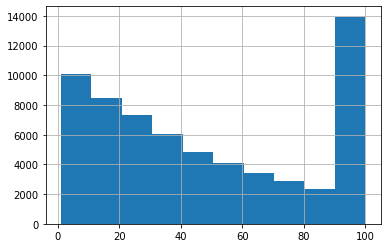

In [35]:
train_set['article_id_idx_last10'].str.split(',').apply(len).hist()

### Filter customers and get customer features

In [36]:
customers = pd.read_csv('data/customers.csv')

In [37]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [38]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [39]:
customers['club_member_status'].unique()

array(['ACTIVE', nan, 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [40]:
customers['fashion_news_frequency'].unique()

array(['NONE', 'Regularly', nan, 'Monthly', 'None'], dtype=object)

In [41]:
customers['postal_code'].nunique()

352899

In [42]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace({'NONE': np.nan, 'None': np.nan})

In [43]:
customers['fashion_news_frequency'].isnull().sum() / customers.shape[0]

0.6514103704135629

In [44]:
customers['fashion_news_frequency'].fillna('MISSING', inplace=True)

In [45]:
customers['club_member_status'].fillna('MISSING', inplace=True)

In [46]:
customers['club_member_status'].unique()

array(['ACTIVE', 'MISSING', 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [47]:
customers['fashion_news_frequency'].unique()

array(['MISSING', 'Regularly', 'Monthly'], dtype=object)

In [48]:
club_member_status_to_idx = {
    'ACTIVE': 0, 
    'MISSING': 1, 
    'PRE-CREATE': 2, 
    'LEFT CLUB': 3
}

In [49]:
fashion_news_frequency_to_idx = {
    'MISSING': 0, 
    'Regularly': 1, 
    'Monthly': 2
}

In [50]:
customers = pd.read_csv('data/customers.csv', usecols=['customer_id', 'FN', 'Active', 'age', 'club_member_status', 'fashion_news_frequency', 'postal_code'])
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [51]:
customers_to_keep = set(train_set['customer_id'])
len(customers_to_keep)

63412

Filter out other customers from submission inputs (for other customers we'll just predict top-12)

In [52]:
len(customers_to_keep) / len(submission_inputs)

0.04654839933904972

In [53]:
submission_inputs = submission_inputs.copy()[submission_inputs['customer_id'].isin(customers_to_keep)]
submission_inputs.shape

(63412, 6)

In [54]:
customers = customers.copy()[customers['customer_id'].isin(customers_to_keep)]
customers.reset_index(drop=True, inplace=True)
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,NaN,NaN,ACTIVE,NONE,27.0,43cbf97df3d118b937551fb21a08d513bfb2e58223315f...
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,ACTIVE,Regularly,33.0,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,NaN,NaN,ACTIVE,NONE,29.0,72afbb92c0200628bfa8f983c241eb0dc14e107f87d95b...
3,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,NaN,NaN,ACTIVE,NONE,23.0,3119ea10ffe5ac3419b9127589a61b33e1ae38ecbb997b...
4,000fb6e772c5d0023892065e659963da90b1866035558e...,1.0,1.0,ACTIVE,Regularly,42.0,68ca4d9d6051d9c10b917d36bf9cb4afbadc551f7e4feb...


In [55]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.540513
Active                    0.547420
club_member_status        0.001419
fashion_news_frequency    0.002602
age                       0.004069
postal_code               0.000000
dtype: float64

In [56]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

Despite potential data leakage we impute the nulls for age here:

In [57]:
customers.shape

(63412, 7)

In [58]:
from sklearn.impute import SimpleImputer

In [59]:
simple_imputer = SimpleImputer()

In [60]:
customers[['age']] = simple_imputer.fit_transform(customers[['age']])

In [61]:
customers['age'] /= 100

In [62]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.000000
Active                    0.000000
club_member_status        0.001419
fashion_news_frequency    0.002602
age                       0.000000
postal_code               0.000000
dtype: float64

In [63]:
customers['customer_id_idx'] = customers.index

Map `club_member_status` and `fashion_frequency` to IDs

In [64]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace({'NONE': np.nan, 'None': np.nan})

In [65]:
customers['fashion_news_frequency'].isnull().sum() / customers.shape[0]

0.5392197060493282

In [66]:
customers['fashion_news_frequency'].fillna('MISSING', inplace=True)

In [67]:
customers['club_member_status'].fillna('MISSING', inplace=True)

In [68]:
customers['fashion_news_frequency_idx'] = customers['fashion_news_frequency'].map(fashion_news_frequency_to_idx)

In [69]:
customers['club_member_status_idx'] = customers['club_member_status'].map(club_member_status_to_idx)

In [70]:
customers.isnull().sum() / customers.shape[0]

customer_id                   0.0
FN                            0.0
Active                        0.0
club_member_status            0.0
fashion_news_frequency        0.0
age                           0.0
postal_code                   0.0
customer_id_idx               0.0
fashion_news_frequency_idx    0.0
club_member_status_idx        0.0
dtype: float64

Postal code

In [71]:
customers['postal_code'].nunique()

54126

In [72]:
customers['postal_code'].value_counts()

2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    999
1f5bd429acc88fbbf24de844a59e438704aa8761bc7b99fd977cad297c50b74c     13
4f88f48fd1345f6ae3a634caadee2d9355d50a34f3ec53c4f9a0532e4180707b      9
f680358c8948524daef52657d1d6f791eb0e4b0e057290c9889c07f37622180b      9
45dc52765eb24eb8bc8a4a40a682d5e430aed58a9aba44e7f67d9516e54ba0d1      8
                                                                   ... 
5b721186855e1fe3266cef02f8ae7e8e471d8885ebb039e66152870fda024e83      1
08f52e22e81abd4f4f749a84f46694d880b3b0de68c515f314373f4671967be4      1
1c4b3b2f7b41c9eef6aa94ed28442537a8098788f4a3873f357905d733323ee9      1
5d113bf4656a7376fcf41e2c730ba688b0fd66d8d47c21417b4df5df0b99871d      1
47258851e6f73dd2583ef4775814f9b88e43a9e2741c645dfb460573726fc1f9      1
Name: postal_code, Length: 54126, dtype: int64

In [73]:
postal_code_df = customers[['postal_code']].drop_duplicates()
postal_code_df.reset_index(drop=True, inplace=True)
print(postal_code_df.shape)
postal_code_df.head()

(54126, 1)


,postal_code
0,43cbf97df3d118b937551fb21a08d513bfb2e58223315f...
1,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...
2,72afbb92c0200628bfa8f983c241eb0dc14e107f87d95b...
3,3119ea10ffe5ac3419b9127589a61b33e1ae38ecbb997b...
4,68ca4d9d6051d9c10b917d36bf9cb4afbadc551f7e4feb...


In [74]:
postal_code_to_idx = dict(zip(postal_code_df['postal_code'], postal_code_df.index.tolist()))

In [75]:
customers['postal_code_idx'] = customers['postal_code'].map(postal_code_to_idx)

In [76]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,0.0,0.0,ACTIVE,MISSING,0.27,43cbf97df3d118b937551fb21a08d513bfb2e58223315f...,0,0,0,0
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,ACTIVE,Regularly,0.33,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...,1,1,0,1
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0.0,0.0,ACTIVE,MISSING,0.29,72afbb92c0200628bfa8f983c241eb0dc14e107f87d95b...,2,0,0,2
3,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,0.0,0.0,ACTIVE,MISSING,0.23,3119ea10ffe5ac3419b9127589a61b33e1ae38ecbb997b...,3,0,0,3
4,000fb6e772c5d0023892065e659963da90b1866035558e...,1.0,1.0,ACTIVE,Regularly,0.42,68ca4d9d6051d9c10b917d36bf9cb4afbadc551f7e4feb...,4,1,0,4


In [77]:
train_set = train_set.merge(customers, on=['customer_id'])

In [78]:
submission_inputs = submission_inputs.merge(customers, on=['customer_id'])

In [79]:
train_set.head()

,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,"32760,29651,41973,6290,31593,4375,40958,37967,...",2020-02-06,28934,1,2.22,0.0,0.0,ACTIVE,MISSING,0.27,43cbf97df3d118b937551fb21a08d513bfb2e58223315f...,0,0,0,0
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"86029,1778,96324,61533,97316,76071,96896,96896...",2020-09-14,87181,1,0.01,1.0,1.0,ACTIVE,Regularly,0.33,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...,1,1,0,1
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"87702,90734,69614,68970,38959,78364,34418,5383...",2020-09-09,"33837,69614,77117","1,1,1",0.06,0.0,0.0,ACTIVE,MISSING,0.29,72afbb92c0200628bfa8f983c241eb0dc14e107f87d95b...,2,0,0,2
3,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"43294,46256,39859,9113,55796,58456,50354,22894...",2020-09-12,"101827,102244,103079,103080,103285,104210,1043...","1,1,1,1,1,1,1,1,1,1,1,1,1,1",0.03,0.0,0.0,ACTIVE,MISSING,0.23,3119ea10ffe5ac3419b9127589a61b33e1ae38ecbb997b...,3,0,0,3
4,000fb6e772c5d0023892065e659963da90b1866035558e...,"90827,76405,101370,79097,62637,89883,17021,946...",2020-09-10,"102870,103396,76557,96449,99876","2,1,1,3,2",0.05,1.0,1.0,ACTIVE,Regularly,0.42,68ca4d9d6051d9c10b917d36bf9cb4afbadc551f7e4feb...,4,1,0,4


In [80]:
train_set = train_set[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age', 'fashion_news_frequency_idx', 'club_member_status_idx', 'postal_code_idx']]

In [81]:
submission_inputs = submission_inputs[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age', 'fashion_news_frequency_idx', 'club_member_status_idx', 'postal_code_idx']]

In [82]:
train_set.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,0,"32760,29651,41973,6290,31593,4375,40958,37967,...",28934,0.0,0.0,0.27,1,2.22,0,0,0
1,1,"86029,1778,96324,61533,97316,76071,96896,96896...",87181,1.0,1.0,0.33,1,0.01,1,0,1
2,2,"87702,90734,69614,68970,38959,78364,34418,5383...","33837,69614,77117",0.0,0.0,0.29,"1,1,1",0.06,0,0,2
3,3,"43294,46256,39859,9113,55796,58456,50354,22894...","101827,102244,103079,103080,103285,104210,1043...",0.0,0.0,0.23,"1,1,1,1,1,1,1,1,1,1,1,1,1,1",0.03,0,0,3
4,4,"90827,76405,101370,79097,62637,89883,17021,946...","102870,103396,76557,96449,99876",1.0,1.0,0.42,"2,1,1,3,2",0.05,1,0,4


In [83]:
submission_inputs.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,0,"32760,29651,41973,6290,31593,4375,40958,37967,...",0,0.0,0.0,0.27,1,-0.05,0,0,0
1,1,"86029,1778,96324,61533,97316,76071,96896,96896...",0,1.0,1.0,0.33,1,-0.07,1,0,1
2,2,"87702,90734,69614,68970,38959,78364,34418,5383...",0,0.0,0.0,0.29,1,-0.06,0,0,2
3,3,"43294,46256,39859,9113,55796,58456,50354,22894...",0,0.0,0.0,0.23,1,-0.06,0,0,3
4,4,"17039,24807,91350,91350,74560,82265,93589,9284...",0,1.0,1.0,0.42,1,-0.06,1,0,4


### Save files

In [84]:
train_set.to_csv('data/final_train_set_with_counts_and_age_extended_100_hist_with_more_cust_feat_for_submission.tsv', sep='\t', index=False)
submission_inputs.to_csv('data/final_submission_inputs_with_counts_and_age_extended_100_hist_with_more_cust_feat_for_submission.tsv', sep='\t', index=False)

articles_df.to_csv('data/articles_df_filt_with_counts_and_age_extended_100_hist_with_more_cust_feat_for_submission.csv', index=False)
customers.to_csv('data/customers_filt_with_counts_and_age_extended_100_hist_with_more_cust_feat_for_submission.csv', index=False)

### IterableDataset

In [70]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str, num_purchases_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        num_purchases = torch.tensor([float(v) for v in num_purchases_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, num_purchases)

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str, example_age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age),
            float(example_age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age, num_purchases, example_age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age, example_age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label, num_purchases)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [81]:
dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age.tsv', article_emb_bag=article_emb_bag, total_articles=total_articles)

In [84]:
pd.read_csv('data/final_train_set_with_counts_and_age.tsv', sep='\t').head(20)

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age
0,0,15861,7705,0.0,0.0,0.45,3,0.42
1,1,"38882,3152,31459,3157,39673,39510,17255,26222,...","3160,35654,38515,39642,40340",1.0,1.0,0.44,"1,1,1,1,1",0.00
2,2,"21627,21175,23351",23816,0.0,0.0,0.21,1,0.25
3,3,"18099,33097,33097,39942,39441,36213","37897,38110,38872",1.0,1.0,0.33,"1,1,1",0.21
4,4,"23950,25602,10293,29865,19920,34107,25721,2152...","10396,15220,15224,21141,23930,37733,37735,37827",0.0,0.0,0.21,"1,1,1,1,1,1,1,1",0.51
5,5,"23368,29644,546,7957","23326,34657,34797,37783",0.0,0.0,0.19,"2,1,1,1",0.32
6,6,"32407,33337,34491,34150,39072,14076,14074,2120...","39072,40138",0.0,0.0,0.36,"1,1",0.02
7,7,"4388,37067,32054,30795,33397,15496,26253,1059,...","24455,30121",0.0,0.0,0.40,"1,1",0.19
8,8,"21970,10865","2471,35881,37827",1.0,1.0,0.22,"1,1,1",0.50
9,9,"25681,24592,30530,2370","23806,30609,37567",1.0,1.0,0.59,"1,1,1",0.35


In [83]:
train_loader = DataLoader(dataset, batch_size=4)  
    
for idx, data in enumerate(train_loader):
    
    if idx == 5:
        break
    else:
        customer_id_idx, inputs, label = data
        print(customer_id_idx)
        print(inputs)
        print(label)
        print(label.max(dim=1))
        print('\n')

tensor([0, 1, 2, 3])
tensor([[-1.2173,  0.1219, -0.2311,  ...,  0.0000,  0.4500,  0.4200],
        [-0.1295, -0.0226,  0.2097,  ...,  1.0000,  0.4400,  0.0000],
        [ 0.0787, -0.0579,  0.0796,  ...,  0.0000,  0.2100,  0.2500],
        [ 0.2321,  0.9143, -1.3484,  ...,  1.0000,  0.3300,  0.2100]],
       grad_fn=<StackBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.return_types.max(
values=tensor([3., 1., 1., 1.]),
indices=tensor([ 7705,  3160, 23816, 37897]))


tensor([4, 5, 6, 7])
tensor([[ 0.4209,  0.1502,  0.3306,  ...,  0.0000,  0.2100,  0.5100],
        [ 0.3754, -0.4886, -0.1319,  ...,  0.0000,  0.1900,  0.3200],
        [-0.6902,  0.3733, -0.0310,  ...,  0.0000,  0.3600,  0.0200],
        [-0.5472,  0.3336,  0.1550,  ...,  0.0000,  0.4000,  0.1900]],
       grad_fn=<StackBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..

torch.return_types.max(
values=tensor([1., 1., 1., 1.]),
indices=tensor([ 1355, 23407, 37585, 18835]))

### TODO

- Wrap processing steps in a function and apply to train, test sets  [DONE]
- Add customer features here (FN, Active, Age)  [DONE]
- Save sets as CSVs  [DONE]
- Save reduced articles df - use to generate correct embeddings by index  [DONE]
- Save customers df - use to generate correct embeddings by index  [DONE]
- Write iterable dataset which processes dataset  [DONE]
    - Get mean for each of inputs and take average to use as input
    - Multi-hot encode label

Checks of proecessing steps:

Multi-hot encoding:

https://discuss.pytorch.org/t/what-kind-of-loss-is-better-to-use-in-multilabel-classification/32203/3

In [101]:
article_id_idx_label = dev_set.iloc[3]['article_id_idx_label']
article_id_idx_label

'18345,38864,35941,32663,39388'

In [72]:
total_articles = articles_df.shape[0]

In [112]:
labels = torch.tensor([int(v) for v in article_id_idx_label.split(',')])
labels

tensor([18345, 38864, 35941, 32663, 39388])

In [111]:
target = torch.zeros(total_articles).scatter_(0, labels, 1.)
target

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [114]:
target[labels]

tensor([1., 1., 1., 1., 1.])

In [115]:
target.sum()

tensor(5.)

Getting mean encoding of historical basket

In [73]:
article_emb_bag = nn.EmbeddingBag(num_embeddings=total_articles, embedding_dim=384)

In [135]:
article_id_idx_last10 = dev_set.iloc[5]['article_id_idx_last10']
article_id_idx_last10

'37757,34393,5646,38997'

In [136]:
indices = torch.tensor([int(v) for v in article_id_idx_last10.split(',')])
indices

tensor([37757, 34393,  5646, 38997])

In [137]:
indices.unsqueeze(0)

tensor([[37757, 34393,  5646, 38997]])

In [138]:
mean_emb = article_emb_bag(indices.unsqueeze(0))
mean_emb.shape

torch.Size([1, 384])

In [139]:
torch.testing.assert_allclose(
    mean_emb.flatten(),
    article_emb_bag.weight[indices].mean(dim=0)
)

In [141]:
mean_emb = article_emb_bag(indices, offsets=torch.tensor([0]))
mean_emb.shape

torch.Size([1, 384])

In [142]:
torch.testing.assert_allclose(
    mean_emb.flatten(),
    article_emb_bag.weight[indices].mean(dim=0)
)